## Requirements

```bash

mamba create -n acnets_bambi
mamba activate acnets_bambi
mamba install python ipykernel
pip install bambi xarray netcdf4
```

In [25]:
import bambi
import arviz as az
import xarray as xr
import re
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
results = xr.open_dataset('models/1_connectivity_classifier_results.nc').load()
split_score_cols = [c for c in list(results.keys()) if re.match(r'split\d+_test_score', c)]
grid_cv_results = results[split_score_cols + ['rank_test_score', 'mean_test_score']].to_pandas()
grid_cv_results.index.name = 'label'
grid_cv_results = grid_cv_results.reset_index()

scores = grid_cv_results
# scores['label'] = scores['params'].apply(lambda p: _create_label(list(p.values())))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)
scores['label'] = scores['label'].apply(lambda x: x.replace('partial correlation', 'partial_correlation'))

scores[['atlas','kind']] = scores['label'].apply(lambda x: x.split(' ')).apply(pd.Series)
scores = scores[['atlas', 'kind', 'test_score']]

In [29]:
model = bambi.Model('test_score ~ 0 + atlas * kind', scores)
fitted = model.fit(tune=100, draws=200, init='adapt_diag')

az.summary(fitted).sort_values('mean', ascending=False)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atlas, kind, atlas:kind, test_score_sigma]


Sampling 4 chains for 100 tune and 200 draw iterations (400 + 800 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.9149, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9159, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9042, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8947, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
atlas[dosenbach2010],4.697,0.083,4.553,4.868,0.004,0.003,414.0,522.0,1.00
atlas[gordon2014_2mm],4.041,0.080,3.892,4.195,0.004,0.003,490.0,593.0,1.01
atlas[difumo_64_2mm],3.660,0.084,3.515,3.822,0.006,0.004,210.0,297.0,1.01
test_score_sigma,1.241,0.015,1.216,1.271,0.000,0.000,969.0,617.0,1.01
"atlas:kind[dosenbach2010, partial_correlation]",0.619,0.169,0.293,0.913,0.011,0.008,247.0,324.0,1.00
kind[precision],0.587,0.121,0.362,0.799,0.008,0.005,261.0,403.0,1.01
"atlas:kind[gordon2014_2mm, tangent]",0.556,0.177,0.172,0.839,0.010,0.007,283.0,444.0,1.01
kind[partial_correlation],0.528,0.116,0.315,0.736,0.008,0.005,237.0,387.0,1.01
"atlas:kind[dosenbach2010, tangent]",0.434,0.174,0.100,0.748,0.011,0.008,268.0,296.0,1.00
kind[covariance],0.298,0.116,0.090,0.510,0.007,0.005,271.0,242.0,1.01


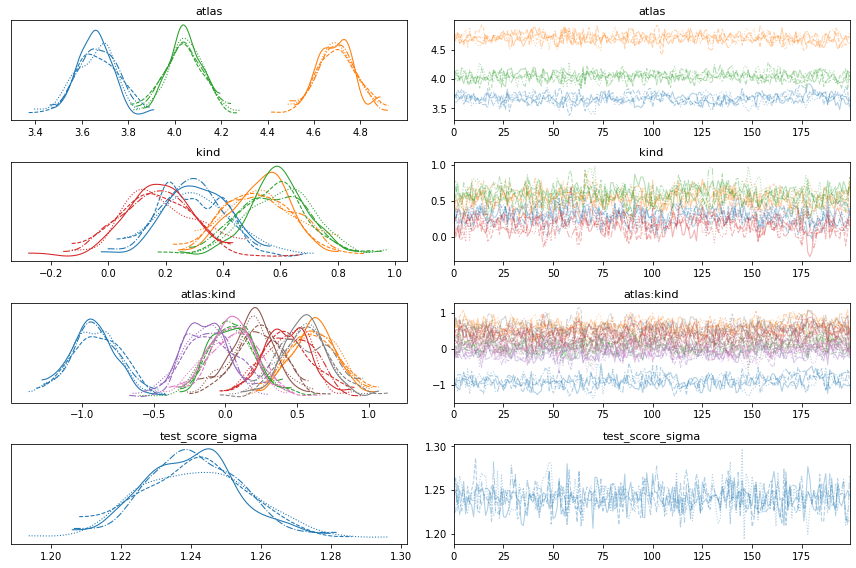

In [31]:
az.plot_trace(fitted)

plt.tight_layout()
plt.show()

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Jun 24 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

arviz : 0.12.1
sys   : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:09:13) [Clang 13.0.1 ]
xarray: 2022.3.0
re    : 2.2.1
bambi : 0.9.0
pandas: 1.4.3

Watermark: 2.3.1

